<h1><font size=12>
Weather Derivatites </h1>
<h1> Rainfall Simulator -- Full modeling <br></h1>

Developed by [Jesus Solano](mailto:ja.solano588@uniandes.edu.co) <br>  
16 September 2018 


In [1]:
# Import needed libraries. 
import numpy as np
import pandas as pd
import random as rand
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
from scipy.stats import gamma
import pickle
import time
import datetime

# Generate artificial Data

In [2]:
### ENSO probabilistic forecast.

# Open saved data.
ensoForecast = pickle.load(open('../datasets/ensoForecastProb/ensoForecastProbabilities.pickle','rb'))

# Print an example .. ( Format needed)

ensoForecast['2005-01']

,Season,La Niña,Neutral,El Niño
0,JFM 2005,0%,15%,85%
1,FMA 2005,0%,17%,83%
2,MAM 2005,1%,24%,75%
3,AMJ 2005,2%,43%,55%
4,MJJ 2005,4%,51%,45%
5,JJA 2005,6%,54%,40%
6,JAS 2005,8%,52%,40%
7,ASO 2005,9%,51%,40%
8,SON 2005,10%,50%,40%
9,OND 2005,10%,50%,40%


In [3]:
### Create total dataframe.

def createTotalDataFrame(daysNumber, startDate , initialState , initialPrep , ensoForecast ):
    # Set variables names.
    totalDataframeColumns = ['state','Prep','Month','probNina','probNino', 'nextState']

    # Create dataframe.

    allDataDataframe = pd.DataFrame(columns=totalDataframeColumns) 

    # Number of simulation days(i.e 30, 60)
    daysNumber = daysNumber

    # Simulation start date ('1995-04-22')
    startDate = startDate

    # State of rainfall last day before start date --> Remember 0 means dry and 1 means wet.
    initialState = initialState
    initialPrep = initialPrep   # Only fill when initialState == 1  


    dates = pd.date_range(startDate, periods = daysNumber + 2 , freq='D')

    for date in dates: 

        # Fill precipitation amount.
        allDataDataframe.loc[date.strftime('%Y-%m-%d'),'Prep'] = np.nan

        # Fill month of date 
        allDataDataframe.loc[date.strftime('%Y-%m-%d'),'Month'] = date.month

        # Fill El Nino ENSO forecast probability. 
        allDataDataframe.loc[date.strftime('%Y-%m-%d'),'probNino'] = float(ensoForecast[date.strftime('%Y-%m')].loc[0,'El Niño'].strip('%').strip('~'))/100

        # Fill La Nina ENSO forecast probability. 
        allDataDataframe.loc[date.strftime('%Y-%m-%d'),'probNina'] = float(ensoForecast[date.strftime('%Y-%m')].loc[0,'La Niña'].strip('%').strip('~'))/100

        # Fill State. 
        allDataDataframe.loc[date.strftime('%Y-%m-%d'),'state'] = np.nan


    simulationDataFrame = allDataDataframe[:-1]

    # Fill initial conditions. 
    simulationDataFrame['state'][0] = initialState
    if initialState == 1:
        simulationDataFrame['Prep'][0] = initialPrep
    else:
        simulationDataFrame['Prep'][0] = 0.0
    
    return simulationDataFrame

simulationDataFrame = createTotalDataFrame(daysNumber= 30, startDate = '2017-08-18', initialState = 1 , initialPrep =  0.4, ensoForecast = ensoForecast)
simulationDataFrame.head()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,state,Prep,Month,probNina,probNino,nextState
2017-08-18,1,0.4,8,0.09,0.09,NaN
2017-08-19,NaN,NaN,8,0.09,0.09,NaN
2017-08-20,NaN,NaN,8,0.09,0.09,NaN
2017-08-21,NaN,NaN,8,0.09,0.09,NaN
2017-08-22,NaN,NaN,8,0.09,0.09,NaN


In [5]:
### Load transitions and amount parameters.

# Transitions probabilites.
transitionsParametersDry = pd.read_csv('../results/visibleMarkov/transitionsParametersDry.csv', sep = ' ', header=None, names = ['variable', 'value'])
transitionsParametersDry.index += 1 
transitionsParametersDry

transitionsParametersWet = pd.read_csv('../results/visibleMarkov/transitionsParametersWet.csv', sep = ' ', header=None, names = ['variable', 'value'])
transitionsParametersWet.index += 1 
transitionsParametersWet

amountParametersGamma = pd.read_csv('../results/visibleMarkov/amountGamma.csv', sep = ' ', header=None, names = ['variable', 'loge(mu)', 'loge(shape)'])
amountParametersGamma.index += 1 
print(transitionsParametersDry)

print('\n * Intercept means firts month (January) ')


       variable     value
1   (Intercept) -1.168017
2        Month2  0.346713
3        Month3  0.848934
4        Month4  1.563185
5        Month5  1.567584
6        Month6  1.132592
7        Month7  1.311161
8        Month8  1.432857
9        Month9  0.924944
10      Month10  1.587704
11      Month11  1.356612
12      Month12  0.518480
13     probNino -0.453497
14     probNina  0.176919

 * Intercept means firts month (January) 


## Simulation Function Core

In [18]:
### Build the simulation core.

# Updates the state of the day based on yesterday state. 
def updateState(yesterdayIndex, simulationDataFrame, transitionsParametersDry, transitionsParametersWet):
    
    # Additional data of day.
    yesterdayState = simulationDataFrame['state'][yesterdayIndex]
    yesterdayPrep = simulationDataFrame['Prep'][yesterdayIndex]
    yesterdayProbNino = simulationDataFrame['probNino'][yesterdayIndex]
    yesterdayProbNina = simulationDataFrame['probNina'][yesterdayIndex]
    yesterdayMonth = simulationDataFrame['Month'][yesterdayIndex]
    
    # Calculate transition probability.
    if yesterdayState == 0:
        
        # Includes month factor + probNino value + probNino value.
        successProbabilityLogit = transitionsParametersDry['value'][yesterdayMonth] + yesterdayProbNino*transitionsParametersDry['value'][13] +  yesterdayProbNina*transitionsParametersDry['value'][14]
        successProbability = (np.exp(successProbabilityLogit))/(1+np.exp(successProbabilityLogit))
    elif yesterdayState == 1:
        
        # Includes month factor + probNino value + probNino value + prep value .
        successProbabilityLogit = transitionsParametersDry['value'][yesterdayMonth] + yesterdayProbNino*transitionsParametersWet['value'][14] +  yesterdayProbNina*transitionsParametersWet['value'][15] + yesterdayPrep*transitionsParametersWet['value'][13] 
        successProbability = (np.exp(successProbabilityLogit))/(1+np.exp(successProbabilityLogit))
    else:
        print('State of date: ', simulationDataFrame.index[yesterdayIndex],' not found.')
    
    #print(successProbability)
    #successProbability = monthTransitions['p'+str(yesterdayState)+'1'][yesterdayMonth] 
    
    todayState = bernoulli.rvs(successProbability)
    
    return todayState 

In [19]:
# Simulates one run of simulation. 
def oneRun(simulationDataFrame, transitionsParametersDry, transitionsParametersWet, amountParametersGamma):
    
    # Define the total rainfall amount over the simulation.
    rainfall = 0
    
    # Loop over days in simulation to calculate rainfall ammount.
    for day in range(1,len(simulationDataFrame)):
        
        # Get today date. 
        dateOfDay = datetime.datetime.strptime(simulationDataFrame.index[day],'%Y-%m-%d')
       
    
        # Update today state based on the yesterday state. 
        todayState = updateState(day-1, simulationDataFrame, transitionsParametersDry, transitionsParametersWet)
        
        # Write new day information.
        simulationDataFrame['state'][day] = todayState
        simulationDataFrame['nextState'][day-1] = todayState
        
        # Computes total accumulated rainfall.
        if todayState == 1:
            
            # Additional data of day.
            todayProbNino = simulationDataFrame['probNino'][day]
            todayProbNina = simulationDataFrame['probNina'][day]
            todayMonth = simulationDataFrame['Month'][day]
    
            
            # Calculates gamma log(mu).
            gammaLogMU = amountParametersGamma['loge(mu)'][todayMonth]+ todayProbNino*amountParametersGamma['loge(mu)'][13]+todayProbNino*amountParametersGamma['loge(mu)'][13] 
            
            # Calculates gamma scale
            gammaLogShape = amountParametersGamma['loge(shape)'][1]
            
            # Update mu
            gammaMu = np.exp(gammaLogMU)
            
            # Update shape
            gammaShape = np.exp(gammaLogShape)
            
            # Calculate gamma scale.
            gammaScale = gammaMu / gammaShape
            
            # Generate random rainfall.
            todayRainfall = gamma.rvs(a = gammaShape, scale = gammaScale)
            
            # Write new day information.
            simulationDataFrame['Prep'][day] = todayRainfall
            
            # Updates rainfall amount. 
            rainfall += todayRainfall
            
        else:
            # Write new day information.
            simulationDataFrame['Prep'][day] = 0
            
        
        yesterdayState = todayState
            
        
    return rainfall

In [20]:
updateState(0, simulationDataFrame, transitionsParametersDry, transitionsParametersWet)

1

In [21]:
# Run only one iteration(Print structure of results)

# Simulations iterations.
iterations = 10000

oneRun(simulationDataFrame, transitionsParametersDry, transitionsParametersWet, amountParametersGamma)


25.81394659510146

## Complete Simulation

In [22]:
# Run total iterations.
def totalRun(simulationDataFrame, transitionsParametersDry, transitionsParametersWet, amountParametersGamma,iterations):
    
    # Initialize time 
    startTime = time.time()
    
    # Array to store all precipitations.
    rainfallPerIteration = [None]*iterations
    
    
    # Loop over each iteration(simulation)
    
    for i in range(iterations):
        
        simulationDataFrameC = simulationDataFrame.copy()
        
        iterationRainfall = oneRun(simulationDataFrameC, transitionsParametersDry, transitionsParametersWet, amountParametersGamma)
        
        rainfallPerIteration[i] = iterationRainfall
    
    # Calculate time
    currentTime = time.time() - startTime 
    
    # Logging time.
    print('The elapsed time over simulation is: ', currentTime, ' seconds.')
    
    return rainfallPerIteration

In [30]:
#### Define parameters simulation.

# Simulations iterations.
iterations = 1000

# Create dataframe to simulate. 
simulationDataFrame = createTotalDataFrame(daysNumber= 30, startDate = '2017-12-18', initialState = 1 , initialPrep =  0.4, ensoForecast = ensoForecast)
simulationDataFrame.head()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,state,Prep,Month,probNina,probNino,nextState
2017-12-18,1,0.4,12,0.83,0,NaN
2017-12-19,NaN,NaN,12,0.83,0,NaN
2017-12-20,NaN,NaN,12,0.83,0,NaN
2017-12-21,NaN,NaN,12,0.83,0,NaN
2017-12-22,NaN,NaN,12,0.83,0,NaN


## Final Results

In [31]:
# Final Analysis.

finalSimulation = totalRun(simulationDataFrame, transitionsParametersDry, transitionsParametersWet, amountParametersGamma,iterations)


The elapsed time over simulation is:  23.72859287261963  seconds.


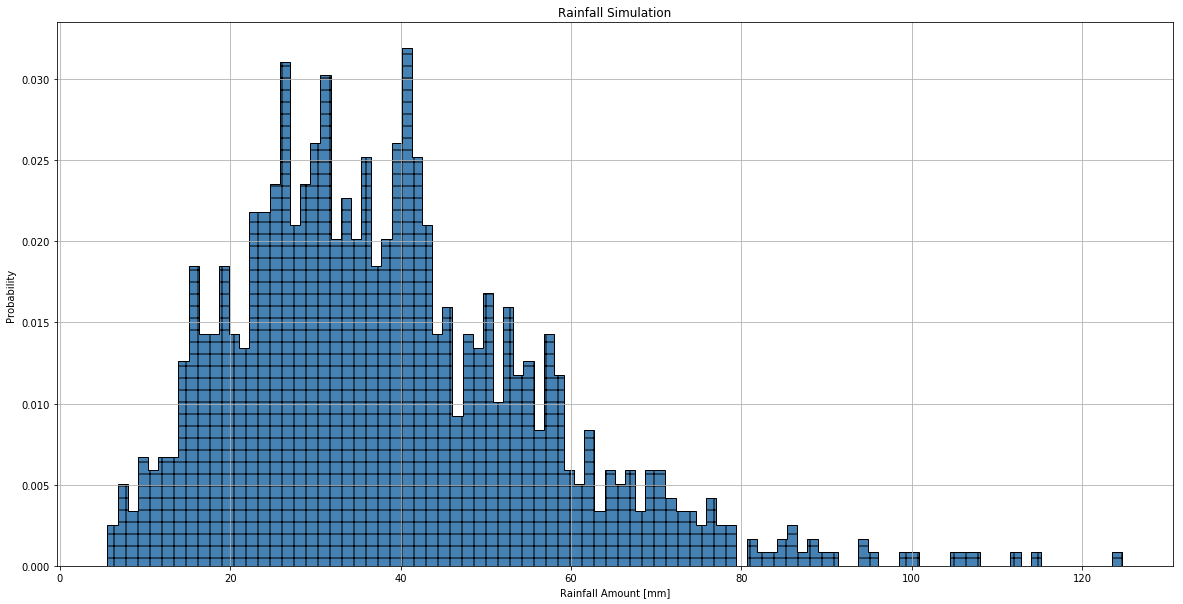

In [32]:
fig = plt.figure(figsize=(20, 10))

plt.hist(finalSimulation,facecolor='steelblue',bins=100, density=True,
         histtype='stepfilled', edgecolor = 'black' , hatch = '+')

plt.title('Rainfall Simulation')
plt.xlabel('Rainfall Amount [mm]')
plt.ylabel('Probability ')
plt.grid()
plt.show()

# Financial Analysis